This notebook will load data, perform a tidal analyis, compare with observations, plot the results, and save the analysis in a spreadsheet.  Eight Tidal Constituents: M2, K1, O1, S2, P1, N2, Q1 and K2 are considered.
- Links consistuents that cannot be separated over 40 days
- Corrects nodal calculations

In [1]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as NC
from scipy.optimize import curve_fit
from salishsea_tools import tidetools
from salishsea_tools import viz_tools
from salishsea_tools import bathy_tools
from salishsea_tools import nc_tools
import collections
import pandas as pd
import csv
import math

from __future__ import division

# Run Details

First, let's define the run that we will be analyzing. We can analyze a different run by changing runname in the cell below. A spreadsheet called tide_runs.ods contains a list of runs that we can look at.

In [2]:
# pathname for data - all of the tide runs are stored in this directory
#path = '/data/nsoontie/MEOPAR/SalishSea/results/tides/'
path = '../../myResults/NEMO36_Tides/'

#the run we want to analyze
#runname = 'corr15'
nemo = '3.6'
runname = 'TS1'

#joining the two string together
name = path +runname +'/'

print name
if nemo == '3.4':
    timeinc = 0
elif nemo == '3.6':
    timeinc = 3259872000.

../../myResults/NEMO36_Tides/TS1/


We'll also load the bathymetry data in case we want to look at that. The package **tidetools** has a function get_SS_bathy_data() that returns bathymetry and grid data.

In [3]:
# grid
grid = NC.Dataset('../../nemo-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

# Observations



Next, we can load some observations from a text file: /data/nsoontie/MEOPAR/analysis/compare_tides/obs_tidal_wlev_const_all.csv Note: This file contains a mix of M2/K1 measurements from Foreman et al (1995), US tidal harmonics, Foreman et al (2004) and Foreman et al (2012) (for Northern tides).


In [4]:
filename = '/data/nsoontie/MEOPAR/analysis/compare_tides/obs_tidal_wlev_const_all.csv'
filename = '../compare_tides/obs_tidal_wlev_const_all.csv'

harm_obs = pd.read_csv(filename,sep=';',header=0)
harm_obs = harm_obs.rename(columns={'Site': 'site', 'Lat': 'lat', 'Lon': 'lon', 
                                    'M2 amp': 'M2_amp', 'M2 phase (deg UT)': 'M2_pha',
                                   'K1 amp': 'K1_amp', 'K1 phase (deg UT)': 'K1_pha'})
print harm_obs

                  site       lat       lon  M2_amp  M2_pha  K1_amp  K1_pha
0                Sooke  48.36700  123.7330    43.8   282.7    56.9   266.4
1         Port Angeles  48.12500  123.4400    51.8   307.4    66.9   261.4
2           Pedder Bay  48.33100  123.5490    34.2   308.0    62.7   269.0
3            Esquimalt  48.43300  123.4330    36.7   317.1    64.3   268.1
4         Clover Point  48.40500  123.3470    40.3   320.3    64.2   269.8
5             Victoria  48.41700  123.3670    37.3   316.1    62.7   269.2
6        Finnerty Cove  48.47300  123.2950    44.7   357.7    70.8   277.5
7        Port Townsend  48.14500  122.7550    65.2   350.0    75.0   270.8
8               Sidney  48.65000  123.4000    55.4     5.9    76.7   277.6
9         Patricia Bay  48.65000  123.4500    60.3    14.4    76.0   281.3
10           Maple Bay  48.81700  123.6170    68.5    17.0    79.3   281.2
11     Fulford Harbour  48.76700  123.4500    58.2    12.7    75.3   280.0
12           Ladysmith  4

This is a list of observations that we can compare with our model output. Now we have a struc object called harm_obs that contains the data printed above.

In [451]:
# Testing to Find the Time Shift

fPA = NC.Dataset(path+runname+'/F1/PointAtkinson_0000.nc')
#nc_tools.show_dataset_attrs(fPA)
nc_tools.show_variables(fPA)
nc_tools.show_variable_attrs(fPA,'time_counter')
print fPA.variables['time_counter'][0]-900.
print fPA.variables['time_centered'][0]

fPO = NC.Dataset('/ocean/sallen/allen/research/MEOPAR/myResults/oldtopog/PointAtkinson.nc')
nc_tools.show_variable_attrs(fPO,'time_counter')
print fPO.variables['time_counter'][0]

RuntimeError: No such file or directory

In [5]:
filename = '../Idalia/other_constituents.csv'

harm_other = pd.read_csv(filename,sep=',',header=0)
harm_other = harm_other.rename(columns={'Site': 'site', 'Lat': 'lat', 'Lon': 'lon', 
                                    'O1 amp': 'O1_amp', 'O1 phase (deg UT)': 'O1_pha',
                                    'P1 amp': 'P1_amp', 'P1 phase (deg UT)': 'P1_pha',
                                    'Q1 amp': 'Q1_amp', 'Q1 phase (deg UT)': 'Q1_pha',
                                    'S2 amp': 'S2_amp', 'S2 phase (deg UT)': 'S2_pha',
                                    'N2 amp': 'N2_amp', 'N2 phase (deg UT)': 'N2_pha',
                                    'K2 amp': 'K2_amp', 'K2 phase (deg UT)': 'K2_pha'})
print harm_other

                  site     lat      lon  O1_amp  O1_pha  P1_amp  P1_pha  \
0             Neah Bay  48.385 -124.616   30.90  231.50   15.50  244.60   
1         Port Renfrew  48.537 -124.476   28.30  234.80   14.07  250.60   
2         Port Angeles  48.129 -123.400   39.10  241.60   20.70  259.40   
3             Victoria  48.413 -123.399   37.00  247.80   19.70  264.60   
4        Port Townsend  48.112 -122.758   45.00  249.90   23.90  268.40   
5               Bangor  47.748 -122.727   46.60  251.90   26.00  273.90   
6              Seattle  47.605 -122.338   45.80  255.40   25.20  274.50   
7               Tacoma  47.267 -122.413   45.90  255.10   25.50  277.20   
8         Cherry Point  48.863 -122.758   45.60  260.00   25.60  281.40   
9        Friday Harbor  48.540 -123.010   42.30  256.40   23.60  274.90   
10       Hanbury Point  48.580 -123.172   43.60  253.60   23.40  271.40   
11              Sidney  48.658 -123.383   44.40  255.80   24.20  275.20   
12     Fulford Harbour  4

# Model

We don't have model output at all of the above locations. The model outputs are listed below. There is a location.nc file in the run directory for each of the stations listed below.

In [6]:
  stations =  ['PortRenfrew','SheringhamPoint','PedderBay', 'Esquimalt',
             'Victoria','CloverPoint','FinnertyCove', 'FulfordHarbour',
            'TumboChannel','PatosIsland','WhalerBay', 'Tsawwassen',
              'Sandheads', 'PointGrey','PointAtkinson','GibsonsLanding', #'WinchelseaIs',
             'HalfmoonBay','IrvinesLanding','PowellRiver', #'LittleRiver', 
               'Lund',
              'TwinIslets','CampbellRiver','MaudeIslandE', 'NympheCove',
              'SeymourNarrows','BrownBay','ChathamPoint','KelseyBay','YorkeIsland']
numsta=len(stations)
#again with spaces because the text file likes that
stations_obs =  ['Port Renfrew','Sheringham Point','Pedder Bay', 'Esquimalt',
                   'Victoria','Clover Point','Finnerty Cove', 'Fulford Harbour',
                    'Tumbo Channel','Patos Island','Whaler Bay', 'Tsawwassen',
                   'Sandheads', 'Point Grey','Point Atkinson','Gibsons Landing', #'Winchelsea',
                    'Halfmoon Bay','Irvines Landing','Powell River', #'Little River', 
                     'Lund',
                    'Twin Islets','Campbell River','Maude Island E', 'Nymphe Cove',
                    'Seymour Narrows','Brown Bay','Chatham Point','Kelsey Bay','Yorke Island']

Next, we can plot these locations on a map of our domain.

0 Port Renfrew
1 Sheringham Point
2 Pedder Bay
3 Esquimalt
4 Victoria
5 Clover Point
6 Finnerty Cove
7 Fulford Harbour
8 Tumbo Channel
9 Patos Island
10 Whaler Bay
11 Tsawwassen
12 Sandheads
13 Point Grey
14 Point Atkinson
15 Gibsons Landing
16 Halfmoon Bay
17 Irvines Landing
18 Powell River
19 Lund
20 Twin Islets
21 Campbell River
22 Maude Island E
23 Nymphe Cove
24 Seymour Narrows
25 Brown Bay
26 Chatham Point
27 Kelsey Bay
28 Yorke Island
8 21


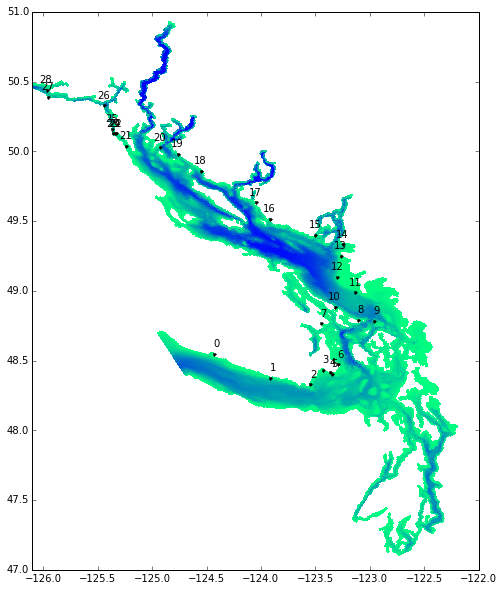

In [7]:
fig,ax=plt.subplots(1, 1, figsize=(8, 10))
ax.pcolormesh(X,Y,bathy,cmap='winter_r')

for stn in range(numsta):
    location = stations_obs[stn]
    lon=-harm_obs.lon[harm_obs.site==location]
    lat=harm_obs.lat[harm_obs.site==location]
    ax.plot(lon,lat,'.k',label=location)
    ax.annotate(stn, xy = (lon,lat), xytext = (5,5),ha = 'right', va = 'bottom',
        textcoords = 'offset points')
    print stn, location
    
ax.axis([-126.1,-122,47,51])
split1=8; split2=21
print split1, split2

Note: Some day it would be worthwhile to place the numbers more carefully so that they don't overlap.

# Tidal Harmonics

PortRenfrew
Victoria
PointAtkinson
NympheCove
0.25 3259872900.0 3259872000.0


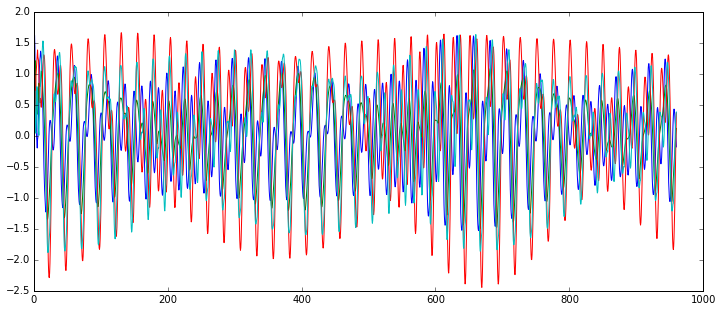

In [8]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
for stn in (0,4,14,23):
    print stations[stn]
    fT1 = NC.Dataset(name+stations[stn]+'.nc','r')
    time = (fT1.variables["time_counter"][:]-timeinc)/3600.  # want hours not seconds
    ssh = fT1.variables["sossheig"][:,0,0]
    ax.plot(time,ssh)
print time[0], fT1.variables['time_counter'][0], timeinc

We need a way of determing the amplitude and phase of M2/K1/O1/S2 from our model output. We will do this by fitting our model water levels to cosine curves with the known frequency of M2/K1/O1/S2.

In [9]:
#constants and fitting
# M2
M2freq = 28.984106 # degrees per hour
M2freq = M2freq*np.pi/180. # radians per hour
#K1
K1freq = 15.041069*np.pi/180.
#O1
O1freq = 13.943036*np.pi/180.
#S2
S2freq = 30.000002*np.pi/180.
#P1
P1freq = 14.958932*np.pi/180.
#N2
N2freq = 28.439730*np.pi/180.
#Q1
Q1freq = 13.398661*np.pi/180.
#K2
K2freq = 30.082138*np.pi/180.

# initial phase calculation
# our start is currently Oct 26, 2002
# data for phase output from bdytides.F90; found in ocean.output
K1ft = 1.050578
K1uvt = 296.314842
M2ft = 0.987843
M2uvt = 245.888564
O1ft = 1.081364
O1uvt = 312.950020
S2ft = 1.0
S2uvt = 0.0
P1ft = 1.0
P1uvt = 55.79460
N2ft = 0.98784
N2uvt = 353.570277
Q1ft = 1.081364
Q1uvt = 60.631733
K2ft = 1.114095
K2uvt = 52.129248

# for start of Apr 21, 2003
new = 'true'
if new == 'true':

    K1ft = 1.065505
    K1uvt = 111.481741
    M2ft = 0.982328
    M2uvt = 250.506179
    O1ft = 1.105495
    O1uvt = 142.040782
    S2ft = 1.000000  
    S2uvt = 0.000000
    P1ft = 1.000000
    P1uvt = 241.335269
    N2ft = 0.982328
    N2uvt = 205.684028
    Q1ft = 1.105495 
    Q1uvt = 97.218631
    K2ft = 1.159036 
    K2uvt = 42.361669
    

However, with our typical 40-day output, we cannot separate K1 from P1 and K2 from S2.  So we want to work ratios with these.

In [10]:
K1_amp_obs=np.zeros(numsta); K1_pha_obs=np.zeros(numsta)
K2_amp_obs=np.zeros(numsta); K2_pha_obs=np.zeros(numsta)
S2_amp_obs=np.zeros(numsta); S2_pha_obs=np.zeros(numsta)
P1_amp_obs=np.zeros(numsta); P1_pha_obs=np.zeros(numsta)

P1K1_amp = np.zeros(numsta); P1K1_pha = np.zeros(numsta)
K2S2_amp = np.zeros(numsta); K2S2_pha = np.zeros(numsta)

for stn in range(numsta):
    location=stations_obs[stn]
    K1_amp_obs[stn]=harm_obs.K1_amp[harm_obs.site==location]/100
    K1_pha_obs[stn]=harm_obs.K1_pha[harm_obs.site==location]
    if (harm_other.site==location).any():
        K2_amp_obs[stn]=harm_other.K2_amp[harm_other.site==location]/100
        K2_pha_obs[stn]=harm_other.K2_pha[harm_other.site==location]
        S2_amp_obs[stn]=harm_other.S2_amp[harm_other.site==location]/100
        S2_pha_obs[stn]=harm_other.S2_pha[harm_other.site==location]
        P1_amp_obs[stn]=harm_other.P1_amp[harm_other.site==location]/100
        P1_pha_obs[stn]=harm_other.P1_pha[harm_other.site==location]
    
    P1K1_amp[stn] = P1_amp_obs[stn] / K1_amp_obs[stn]
    P1K1_pha[stn] = P1_pha_obs[stn] - K1_pha_obs[stn]
    K2S2_amp[stn] = K2_amp_obs[stn] / S2_amp_obs[stn]
    K2S2_pha[stn] = K2_pha_obs[stn] - S2_pha_obs[stn]
    

In [11]:
def interpolate_ratios(amp_ratio, pha_diff):
    for stn in range(numsta):
        if (amp_ratio[stn] == 0) or (np.isnan(amp_ratio[stn])):
            if (amp_ratio[stn-1] != 0) and not(np.isnan(amp_ratio[stn-1])):
                if amp_ratio[stn+1] != 0 and not(np.isnan(amp_ratio[stn+1])):
                    amp_ratio[stn] = 0.5*(amp_ratio[stn-1] + amp_ratio[stn+1])
                    pha_diff[stn] = 0.5*(pha_diff[stn-1] + pha_diff[stn+1])
                else:
                    amp_ratio[stn] = amp_ratio[stn-1]
                    pha_diff[stn] = pha_diff[stn-1]
            elif (amp_ratio[stn+1] != 0) and not(np.isnan(amp_ratio[stn+1])):
                amp_ratio[stn] = amp_ratio[stn+1]
                pha_diff[stn] = pha_diff[stn+1]
            print stations[stn], amp_ratio[stn]

In [12]:
interpolate_ratios(P1K1_amp, P1K1_pha)

SheringhamPoint 0.31059602649
PedderBay 0.31059602649
Esquimalt 0.312395301921
CloverPoint 0.314194577352
FinnertyCove 0.312475774732
TumboChannel 0.310441777195
WhalerBay 0.310339070516
Sandheads 0.310551558753
PointGrey 0.310728215571
GibsonsLanding 0.31090487239
HalfmoonBay 0.31090487239
IrvinesLanding 0.31090487239
PowellRiver 0.31090487239
Lund 0.313748896372
MaudeIslandE 0.290780141844
NympheCove 0.299147296356
BrownBay 0.309644075586
KelseyBay 0.309112656605


In [13]:
interpolate_ratios(K2S2_amp, K2S2_pha)

SheringhamPoint 0.233840304183
PedderBay 0.233840304183
Esquimalt 0.214959367778
CloverPoint 0.196078431373
FinnertyCove 0.23832698547
TumboChannel 0.286994356611
WhalerBay 0.286706586826
Sandheads 0.28
PointGrey 0.275371179039
GibsonsLanding 0.270742358079
HalfmoonBay 0.270742358079
IrvinesLanding 0.270742358079
PowellRiver 0.270742358079
Lund 0.269375826599
MaudeIslandE 0.26739023187
NympheCove 0.270629374276
BrownBay 0.273653008342
KelseyBay 0.275463563278


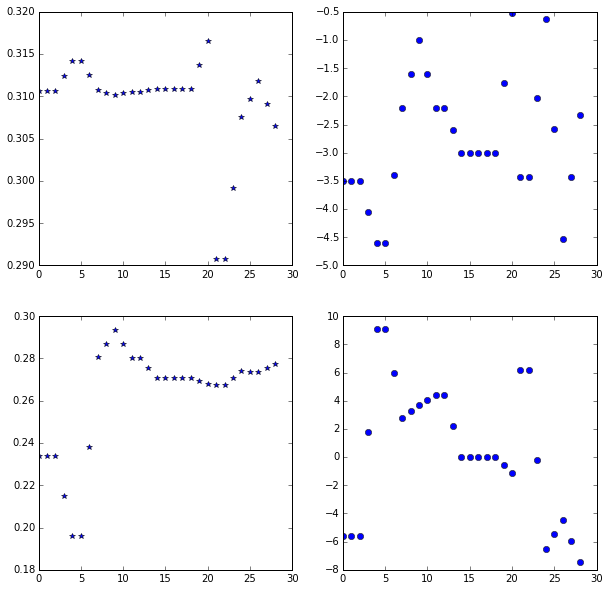

In [14]:
fig,ax = plt.subplots(2, 2, figsize=(10,10))
ax[0,0].plot(P1K1_amp, '*')
ax[0,1].plot(P1K1_pha, 'o')
ax[1,0].plot(K2S2_amp, '*')
ax[1,1].plot(K2S2_pha, 'o')

In [15]:
# function for fitting 6 frequencies and inferring 2 with constant
def sixplustwo(xplus, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha, S2amp, S2pha,
                 N2amp, N2pha, Q1amp, Q1pha, Constant):
    x = xplus[0]

    P1K1amp = xplus[1]
    P1K1pha = xplus[2]
    K2S2amp = xplus[3]
    K2S2pha = xplus[4]
    
    return (M2amp * M2ft * np.cos(M2freq*x - (M2pha - M2uvt) *np.pi/180.) +
             K1amp * K1ft * np.cos(K1freq*x - (K1pha - K1uvt) *np.pi/180.) +
             O1amp * O1ft * np.cos(O1freq*x - (O1pha - O1uvt) *np.pi/180.) +
             S2amp * S2ft * np.cos(S2freq*x - (S2pha - S2uvt) *np.pi/180.) +
             P1K1amp * K1amp *P1ft * np.cos(P1freq*x - (K1pha + P1K1pha - P1uvt) *np.pi/180.) +
             N2amp * N2ft * np.cos(N2freq*x - (N2pha - N2uvt) *np.pi/180.) +
             Q1amp * Q1ft * np.cos(Q1freq*x - (Q1pha - Q1uvt) *np.pi/180.) +
             K2S2amp * S2amp *K2ft * np.cos(K2freq*x - (S2pha + K2S2pha - K2uvt) *np.pi/180.) + Constant )

Now we can apply this fit to our model output.

### Use Full Time Series for Best Estimate of Amplitudes/Phases

In [16]:
#allocate space for our arrays
M2_amp=[]; M2_pha=[]; K1_amp=[]; K1_pha=[]
O1_amp=[]; O1_pha=[]; S2_amp=[]; S2_pha=[]
N2_amp=[]; N2_pha=[]
Q1_amp=[]; Q1_pha=[]

M2_amp_obs=np.zeros(numsta); M2_pha_obs=np.zeros(numsta)
N2_amp_obs=np.zeros(numsta); N2_pha_obs=np.zeros(numsta)
Q1_amp_obs=np.zeros(numsta); Q1_pha_obs=np.zeros(numsta)
O1_amp_obs=np.zeros(numsta); O1_pha_obs=np.zeros(numsta)

ts = 240
te = ssh.shape[0]
timeplus = np.zeros([5,te-ts])

for stn in range(numsta):
    print name+stations[stn]
    fT1 = NC.Dataset(name+stations[stn]+'.nc','r')
    time = (fT1.variables["time_counter"][ts:te]-timeinc)/3600.  # want hours not seconds
    ssh = fT1.variables["sossheig"][:,0,0]
    timeplus[0] = time
    timeplus[1] = P1K1_amp[stn]*np.ones_like(time); timeplus[2] = P1K1_pha[stn]*np.ones_like(time)
    timeplus[3] = K2S2_amp[stn]*np.ones_like(time); timeplus[4] = K2S2_pha[stn]*np.ones_like(time)

    fitted, cov = curve_fit(sixplustwo,timeplus,ssh[ts:te]) 
    if fitted[0] < 0:
        fitted[0] = -fitted[0]
        fitted[1] = fitted[1]+180

    M2_amp.append(fitted[0])
    pha = fitted[1]
    if  pha > 360:
        pha=pha-360
    elif pha < 0:
        pha = pha+360
    if stn == 6:
        print pha
    M2_pha.append(pha)

    if fitted[2] < 0:
        fitted[2] = - fitted[2]
        fitted[3] = fitted[3] + 180
    K1_amp.append(fitted[2])
    pha = fitted[3]
    if  pha > 360:
        pha = pha-360
    elif pha < 0:
        pha = pha + 360
    K1_pha.append(pha)  
    
    if fitted[4] < 0:
        fitted[4] = -fitted[4]
        fitted[5] = fitted[5]+180
    O1_amp.append(fitted[4])
    pha= fitted[5]
    if  pha > 360:
        pha=pha-360
    elif pha < 0:
        pha = pha + 360
    O1_pha.append(pha) 
    
    if fitted[6] < 0:
        fitted[6] = -fitted[6]
        fitted[7] = fitted[7]+180
    S2_amp.append(fitted[6])
    pha= fitted[7]
    if  pha > 360:
        pha=pha-360
    elif pha < 0:
        pha = pha + 360
    S2_pha.append(pha) 
    
    if fitted[8] < 0:
            fitted[8] = -fitted[8]
            fitted[9] = fitted[9]+180
    N2_amp.append(fitted[8])
    pha= fitted[9]
    if  pha > 360:
        pha=pha-360
    elif pha < 0:
        pha = pha + 360
    N2_pha.append(pha) 
    
    if fitted[10] < 0:
            fitted[10] = -fitted[10]
            fitted[11] = fitted[11]+180
    Q1_amp.append(fitted[10])
    pha= fitted[11]
    if  pha > 360:
        pha=pha-360
    Q1_pha.append(pha) 

    #now the observations
    location=stations_obs[stn]
    M2_amp_obs[stn]=harm_obs.M2_amp[harm_obs.site==location]/100
    M2_pha_obs[stn]=harm_obs.M2_pha[harm_obs.site==location]
    K1_amp_obs[stn]=harm_obs.K1_amp[harm_obs.site==location]/100
    K1_pha_obs[stn]=harm_obs.K1_pha[harm_obs.site==location]
    
    #O1/S2/P1/N2/Q1/K2 are in the other file
    if (harm_other.site==location).any():
        O1_amp_obs[stn]=harm_other.O1_amp[harm_other.site==location]/100
        O1_pha_obs[stn]=harm_other.O1_pha[harm_other.site==location]
        S2_amp_obs[stn]=harm_other.S2_amp[harm_other.site==location]/100
        S2_pha_obs[stn]=harm_other.S2_pha[harm_other.site==location]
        N2_amp_obs[stn]=harm_other.N2_amp[harm_other.site==location]/100
        N2_pha_obs[stn]=harm_other.N2_pha[harm_other.site==location]
        Q1_amp_obs[stn]=harm_other.Q1_amp[harm_other.site==location]/100
        Q1_pha_obs[stn]=harm_other.Q1_pha[harm_other.site==location]
    #Mask the arrays so that we can do statistics without the 0's throwing things off.
    O1_amp_obs =np.ma.masked_values(O1_amp_obs, 0)
    O1_pha_obs =np.ma.masked_values(O1_pha_obs, 0)
    S2_amp_obs =np.ma.masked_values(S2_amp_obs, 0)
    S2_pha_obs =np.ma.masked_values(S2_pha_obs, 0)
    N2_amp_obs =np.ma.masked_values(N2_amp_obs, 0)
    N2_pha_obs =np.ma.masked_values(N2_pha_obs, 0)
    Q1_amp_obs =np.ma.masked_values(Q1_amp_obs, 0)
    Q1_pha_obs =np.ma.masked_values(Q1_pha_obs, 0)

../../myResults/NEMO36_Tides/TS1/PortRenfrew
../../myResults/NEMO36_Tides/TS1/SheringhamPoint
../../myResults/NEMO36_Tides/TS1/PedderBay
../../myResults/NEMO36_Tides/TS1/Esquimalt
../../myResults/NEMO36_Tides/TS1/Victoria
../../myResults/NEMO36_Tides/TS1/CloverPoint
../../myResults/NEMO36_Tides/TS1/FinnertyCove
357.581474077
../../myResults/NEMO36_Tides/TS1/FulfordHarbour
../../myResults/NEMO36_Tides/TS1/TumboChannel
../../myResults/NEMO36_Tides/TS1/PatosIsland
../../myResults/NEMO36_Tides/TS1/WhalerBay
../../myResults/NEMO36_Tides/TS1/Tsawwassen
../../myResults/NEMO36_Tides/TS1/Sandheads
../../myResults/NEMO36_Tides/TS1/PointGrey
../../myResults/NEMO36_Tides/TS1/PointAtkinson
../../myResults/NEMO36_Tides/TS1/GibsonsLanding
../../myResults/NEMO36_Tides/TS1/HalfmoonBay
../../myResults/NEMO36_Tides/TS1/IrvinesLanding
../../myResults/NEMO36_Tides/TS1/PowellRiver
../../myResults/NEMO36_Tides/TS1/Lund
../../myResults/NEMO36_Tides/TS1/TwinIslets
../../myResults/NEMO36_Tides/TS1/CampbellRiver

The model data is saved in lists M2_amp, M2_pha, K1_amp, K1_pha. We have also saved the observations in M2_amp_obs, etc.

We can compare model and observations by plotting.

In [18]:
print M2_pha[4], M2_pha[14], M2_pha[14]-M2_pha[4]+360

305.855845082 30.9335482805 85.0777031986


In [19]:
print M2_pha_obs[4], M2_pha_obs[14], M2_pha_obs[14]+360-M2_pha_obs[4]

316.1 31.2 75.1


In [20]:
print M2_amp_obs

[ 0.708  0.487  0.342  0.367  0.373  0.403  0.447  0.582  0.726  0.68
  0.834  0.811  0.869  0.945  0.918  0.947  0.964  0.988  1.007  1.022
  1.013  0.825  0.556  0.615  0.946  0.935  0.903  1.17   1.171]


0.987992406088
0.29234517195
0.976685476365
0.303024727177


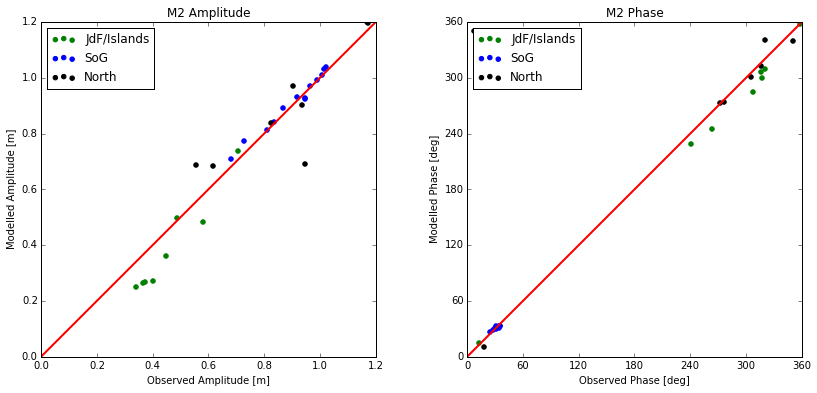

In [21]:
#Plotting M2
labels=['JdF/Islands','SoG','North']
fig=tidetools.plot_scatter_pha_amp(M2_amp,M2_amp_obs,M2_pha,M2_pha_obs,'M2',figsize=(14,6),
                                   split1=split1,split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

print np.mean(M2_amp_obs[split1:split2]/M2_amp[split1:split2])
print np.mean(M2_pha_obs[split1:split2]-M2_pha[split1:split2])

print np.mean(M2_amp_obs[-2:]/M2_amp[-2:])
print np.mean(M2_pha_obs[-2:]-M2_pha[-2:])

1.05853130556
-13.2007577771
1.00634873605
-52.8994217155


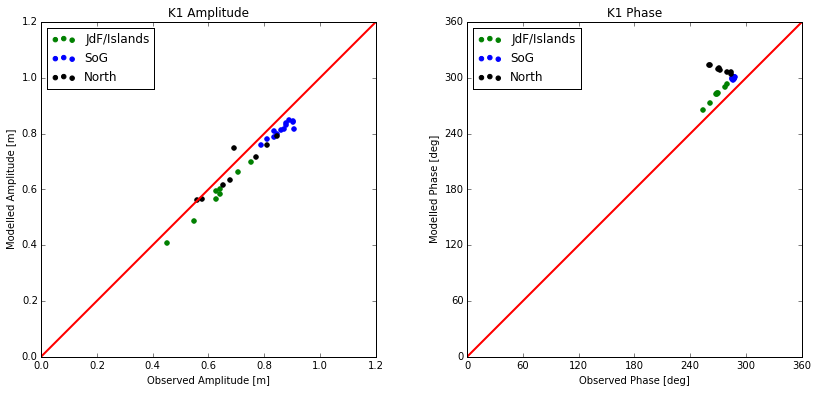

In [22]:
#Plotting - K1

fig=tidetools.plot_scatter_pha_amp(K1_amp,K1_amp_obs,K1_pha,K1_pha_obs,'K1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

print np.mean(K1_amp_obs[split1:split2]/K1_amp[split1:split2])
print np.mean(K1_pha_obs[split1:split2]-K1_pha[split1:split2])
print np.mean(K1_amp_obs[-2:]/K1_amp[-2:])
print np.mean(K1_pha_obs[-2:]-K1_pha[-2:])

1.00295905247
2.30389378226
1.03654427098
-0.422411258873


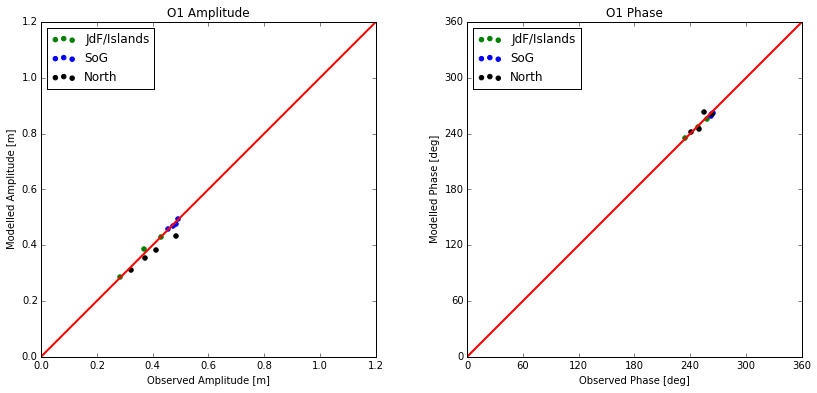

In [23]:
#Plotting - O1

fig=tidetools.plot_scatter_pha_amp(O1_amp,O1_amp_obs,O1_pha,O1_pha_obs,'O1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
print np.mean(O1_amp_obs[split1:split2]/O1_amp[split1:split2])
print np.mean(O1_pha_obs[split1:split2]-O1_pha[split1:split2])
print np.mean(O1_amp_obs[-2:]/O1_amp[-2:])
print np.mean(O1_pha_obs[-2:]-O1_pha[-2:])

0.953071257545
5.71981155334
1.00044973321
1.97828211877


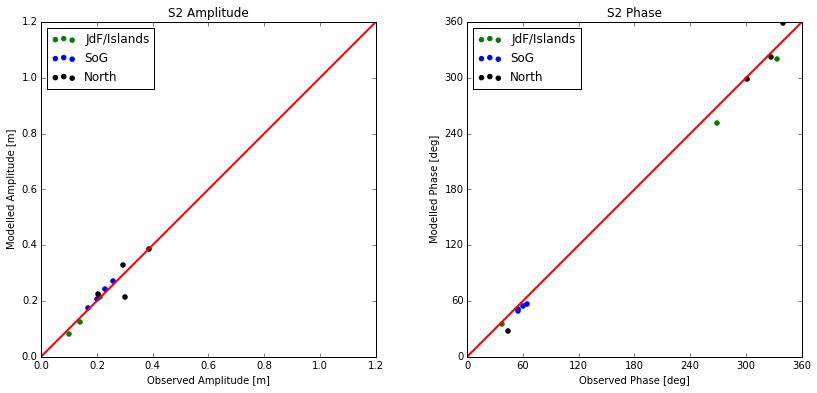

In [24]:
#Plotting - S2

fig=tidetools.plot_scatter_pha_amp(S2_amp,S2_amp_obs,S2_pha,S2_pha_obs,'S2',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
print np.mean(S2_amp_obs[split1:split2]/S2_amp[split1:split2])
print np.mean(S2_pha_obs[split1:split2]-S2_pha[split1:split2])
print np.mean(S2_amp_obs[-2:]/S2_amp[-2:])
print np.mean(S2_pha_obs[-2:]-S2_pha[-2:])

0.933189179305
1.06546034319
0.979998814643
0.0821894633856


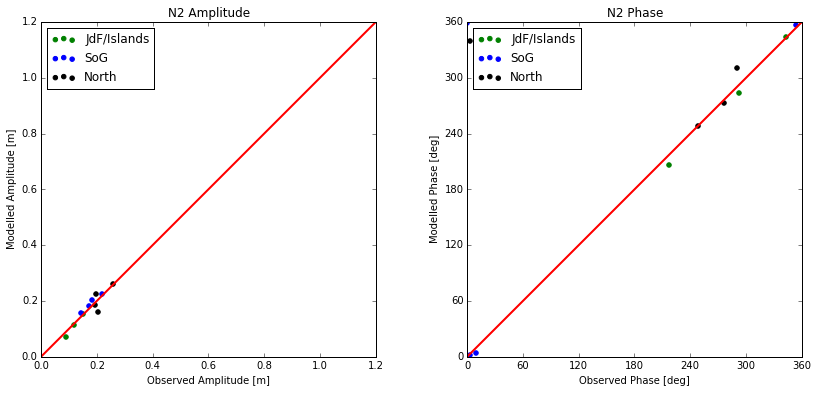

In [25]:
#Plotting - N2

fig=tidetools.plot_scatter_pha_amp(N2_amp,N2_amp_obs,N2_pha,N2_pha_obs,'N2',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
print np.mean(N2_amp_obs[split1:split2]/N2_amp[split1:split2])
print np.mean(N2_pha_obs[split1:split2]-N2_pha[split1:split2])+360/4.
print np.mean(N2_amp_obs[-2:]/N2_amp[-2:])
print np.mean(N2_pha_obs[-2:]-N2_pha[-2:])

1.00025725476
[-- 0.817716688711414 -- 4.948276633709497 -- -- 3.3514723227502827 -- --
 -- -- -- 2.912713356441884]
3.0075447504
1.26343899538
[-- -17.096293558632283]
-17.0962935586


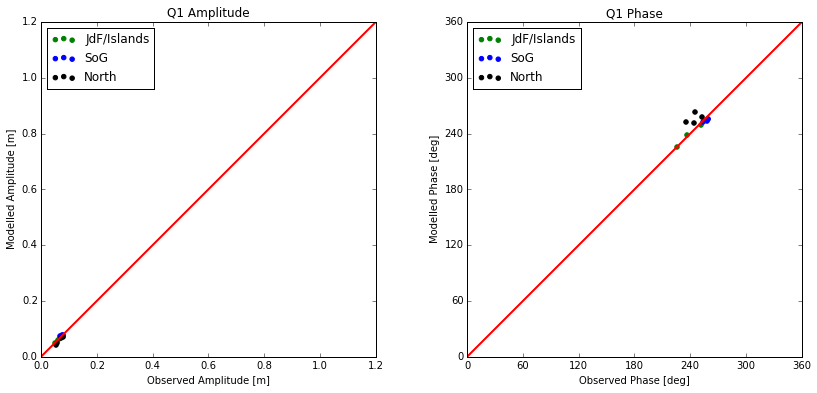

In [28]:
#Plotting - Q1

fig=tidetools.plot_scatter_pha_amp(Q1_amp,Q1_amp_obs,Q1_pha,Q1_pha_obs,'Q1',figsize=(14,6),
                                   split1=split1, split2=split2, labels=labels)

ax_amp,ax_pha = fig.axes
min_value, max_value = ax_amp.set_xlim(0, 1.2)
ax_amp.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)

min_value, max_value = ax_pha.set_xlim(0, 360)
ax_pha.plot([min_value, max_value], [min_value, max_value], color='red',lw=2)
print np.mean(Q1_amp_obs[split1:split2]/Q1_amp[split1:split2])
print Q1_pha_obs[split1:split2]-Q1_pha[split1:split2]
print np.mean(Q1_pha_obs[split1:split2]-Q1_pha[split1:split2])
print np.mean(Q1_amp_obs[-2:]/Q1_amp[-2:])
print Q1_pha_obs[-2:]-Q1_pha[-2:]
print np.mean(Q1_pha_obs[-2:]-Q1_pha[-2:])

The model performs well when the dots are close to the red line.

# Statistics

We would like to save some statistics so that we can determine which runs give us the best match with observations. So, we will define some functions that will help us calculate statistics.

### Mean Error (absolute value)

In [29]:
def mean(diff):
    return np.mean(abs(diff))

### RMS Error

In [30]:
def rms(diff):
    return np.sqrt(np.mean(diff**2))

### Complex differences

This is a way of measuring distances in the complex plane. We can think of our tidal amplitude and phase as a point on the complex plane. So we would like to measure the distance between a point given by the model and a point given by the observations. The function below does this.

In [31]:
def complex_diff(Ao,go,Am,gm):
    #calculates complex differences between observations and model
    #Ao, go - amplitude and phase from observations
    #Am, gm - amplitude and phase from model
    D = np.sqrt((Ao*np.cos(np.pi*go/180)-Am*np.cos(np.pi*gm/180))**2 + 
                (Ao*np.sin(np.pi*go/180)-Am*np.sin(np.pi*gm/180))**2)
    
    return D

Some other things we will look at are

$R = \frac{A_m}{A_o}$, the ratio of modelled to observed amplitude and 

$\Delta \phi = \phi_m - \phi_o$, the difference betwen modelled and observed phase.

In [32]:
#R
R_M2 = M2_amp/M2_amp_obs
R_K1 = K1_amp/K1_amp_obs
#delta phi (adjust so between -180, 180)
Dphi_M2 = M2_pha-M2_pha_obs; 
Dphi_M2 = Dphi_M2 -360*(Dphi_M2>180) + 360*(Dphi_M2<-180)
Dphi_K1 = K1_pha-K1_pha_obs
Dphi_K1 = Dphi_K1 -360*(Dphi_K1>180) + 360*(Dphi_K1<-180)
#Complex differences
D_M2= complex_diff(np.array(M2_amp_obs),np.array(M2_pha_obs), np.array(M2_amp),np.array(M2_pha))
D_K1= complex_diff(np.array(K1_amp_obs),np.array(K1_pha_obs), np.array(K1_amp),np.array(K1_pha))
D_O1= complex_diff(np.ma.array(O1_amp_obs),np.ma.array(O1_pha_obs), np.ma.array(O1_amp),np.ma.array(O1_pha))
D_S2= complex_diff(np.ma.array(S2_amp_obs),np.ma.array(S2_pha_obs), np.ma.array(S2_amp),np.ma.array(S2_pha))
D_N2= complex_diff(np.ma.array(N2_amp_obs),np.ma.array(N2_pha_obs), np.ma.array(N2_amp),np.ma.array(N2_pha))
D_Q1= complex_diff(np.ma.array(Q1_amp_obs),np.ma.array(Q1_pha_obs), np.ma.array(Q1_amp),np.ma.array(Q1_pha))

# Saving the results

We will now save these statistics in a spreadsheet

In [33]:
outfile = runname+'.csv'

with open(outfile, 'wb') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow([
            'Station Name', 
            'R (M2)', 'Delta phi (M2)', 'D (M2)',
            'R (K1)', 'Delta phi (K1)', 'D (K1)'
        ])
    for stn in range(numsta):
        location = stations_obs[stn]
        writer.writerow([stations_obs[stn],
                        R_M2[stn], Dphi_M2[stn], D_M2[stn],
                        R_K1[stn], Dphi_K1[stn], D_K1[stn]])

    #write averages and rms
    writer.writerow(['Mean Difference',
                    mean(M2_amp-M2_amp_obs),mean(Dphi_M2),mean(D_M2), 
                    mean(K1_amp-K1_amp_obs),mean(Dphi_K1),mean(D_K1)])
    writer.writerow(['RMS Difference',
                    rms(M2_amp-M2_amp_obs),rms(Dphi_M2),rms(D_M2), 
                    rms(K1_amp-K1_amp_obs),rms(Dphi_K1),rms(D_K1)])
    #without the north
    writer.writerow(['Mean Difference no North no PR',
                    mean(M2_amp[1:split2]-M2_amp_obs[1:split2]),mean(Dphi_M2[1:split2]),mean(D_M2[1:split2]), 
                    mean(K1_amp[1:split2]-K1_amp_obs[1:split2]),mean(Dphi_K1[1:split2]),mean(D_K1[1:split2])])
    writer.writerow(['RMS Difference no North no PR',
                    rms(M2_amp[1:split2]-M2_amp_obs[1:split2]),rms(Dphi_M2[1:split2]),rms(D_M2[1:split2]), 
                    rms(K1_amp[1:split2]-K1_amp_obs[1:split2]),rms(Dphi_K1[1:split2]),rms(D_K1[1:split2])])

Now there is a csv file in this directory with data about this run. It should be called runname.csv (where runname is the string we  defined at the beginning of the notebook).

Things to try:
1. Add the complex differences information printed in the .csv file to tide_runs.ods. Also, if you notice any discrepancies, you can correct them. (Check M2 amplitude at Yorke Island)
2. Work through the notebook with a different run. There is a list of runs in tide_runs.ods
3. Commit and push any changes you've made to this notebook and tide_runs.odt.  
Try this:
    * hg status (see what changes have been made)
    * hg in
    * hg commit mynotebook.ipynb (write a commit message and then save and exit)
    * hg commit tide_runs.odt
    * hg pull --rebase
    * pg push
    
4. Add any new csv files to the repository.
Try this:
    * hg add filename.csv
    * hg commit filename.csv
    * hg pull --rebase
    * hg push
    
5. Repeat with all the runs listed in tide_runs.odt

# Plots comparing measured and model amplitudes and phases

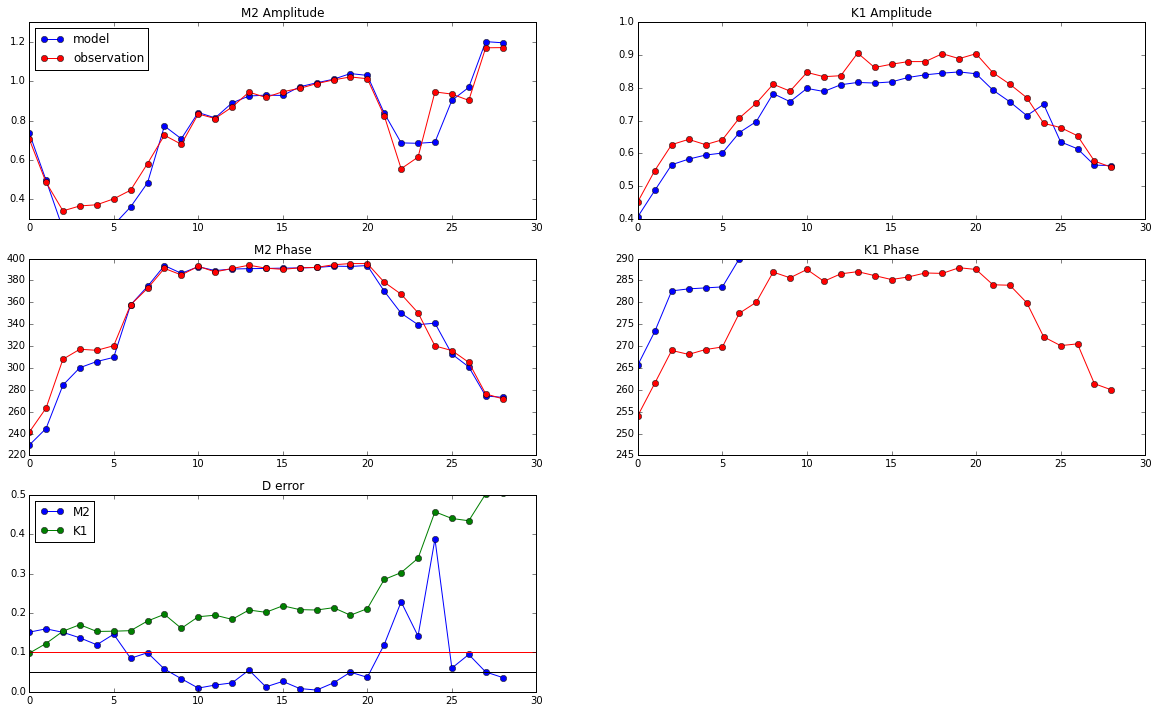

In [34]:
plt.figure(figsize=(20,12))

plt.subplot(3,2,1)
plt.plot(np.array(M2_amp), '-bo', label = 'model')
plt.plot(M2_amp_obs, 'r-o', label = 'observation')
plt.ylim((0.3,1.3))
plt.title('M2 Amplitude')
plt.legend( loc='upper left' )

plt.subplot(3,2,2)
plt.plot(np.array(K1_amp), '-bo', label = 'model')
plt.plot(K1_amp_obs, 'r-o', label = 'observation')
plt.title('K1 Amplitude')

plt.subplot(3,2,3)
# use the un-wrap function to plot the M2 phase more smoothly
pha_uwm = 180./np.pi * np.unwrap((np.array(M2_pha))*np.pi/180.)
plt.plot(pha_uwm, '-bo', label = 'model')
pha_uw = 180./np.pi * np.unwrap(np.array(M2_pha_obs)*np.pi/180.)
plt.plot(pha_uw, 'r-o', label = 'observation')
plt.title('M2 Phase')

plt.subplot(3,2,4)
pha_uw = 180./np.pi * np.unwrap((np.array(K1_pha))*np.pi/180.)
plt.plot(pha_uw, '-bo', label = 'model')
plt.plot(K1_pha_obs, 'r-o', label = 'observation')
plt.ylim((245,290))
plt.title('K1 Phase')

plt.subplot(3,2,5)
plt.plot(D_M2, '-bo', label = 'M2')
plt.plot(D_K1, '-go', label = 'K1')
plt.plot((0,30),(0.05,0.05),'k')
plt.plot((0,30),(0.10,0.10),'r')
plt.ylim((0,0.5))
plt.title('D error')
plt.legend( loc='upper left' )


0.263373698254
0.37125


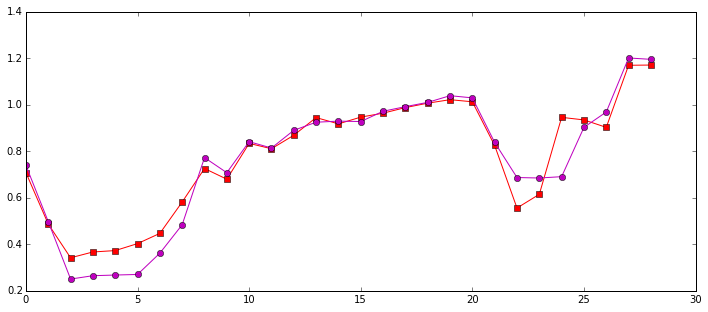

In [37]:
plt.figure(figsize=(12,5))
plt.plot(M2_amp_obs, 'r-s', label = 'observation')
plt.plot(M2_amp, '-mo', label='results')
print np.mean(M2_amp[2:6])
print np.mean(M2_amp_obs[2:6])

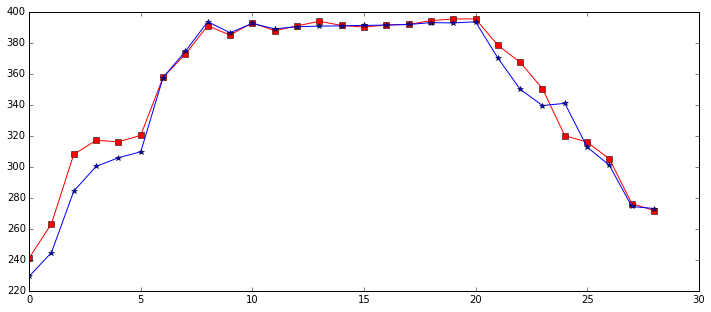

In [38]:
plt.figure(figsize=(12,5))
pha_uw = 180./np.pi * np.unwrap(np.array(M2_pha_obs)*np.pi/180.)
plt.plot(pha_uw, 'r-s', label = 'observation')
pha_uw_mod = 180./np.pi * np.unwrap(np.array(M2_pha)*np.pi/180.)
plt.plot(pha_uw_mod, 'b*-', label='results')

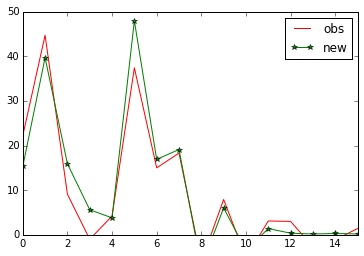

In [39]:
diffy_obs = pha_uw[1:]-pha_uw[0:-1]
diffy_new = pha_uw_mod[1:]-pha_uw_mod[:-1]

plt.plot(diffy_obs,'r',label='obs')
plt.plot(diffy_new,'g*-', label='new')

plt.xlim((0,15))
plt.ylim((0,50))
plt.legend()

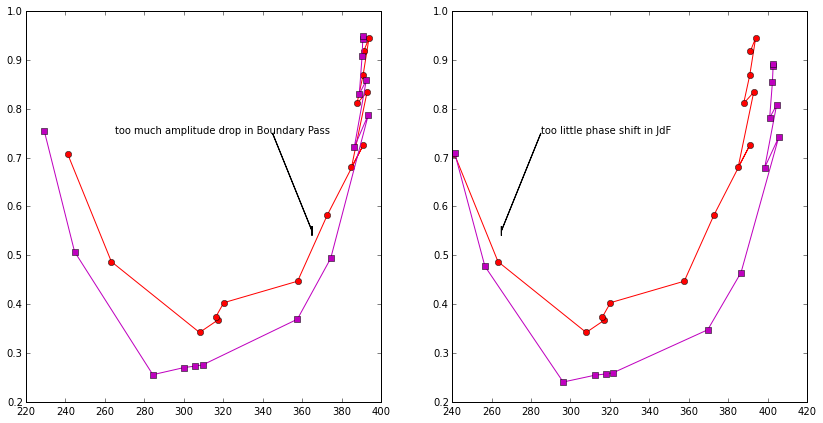

In [50]:
je=15
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(pha_uw[:je], M2_amp_obs[:je],'ro-')
plt.plot(pha_uw_mod[:je],np.array(M2_amp[:je])*1.02,'ms-')

plt.arrow(365-20, 0.55+0.2, 20, -0.2)
plt.text(365-100, 0.55+0.2, "too much amplitude drop in Boundary Pass")
plt.subplot(1,2,2)
plt.plot(pha_uw[:je], M2_amp_obs[:je],'ro-')

plt.plot(pha_uw_mod[:je]+12.,np.array(M2_amp[:je])*0.96,'ms-')
plt.arrow(265+20, 0.55+0.2, -20, -0.2)
plt.text(265+20, 0.55+0.2, "too little phase shift in JdF")

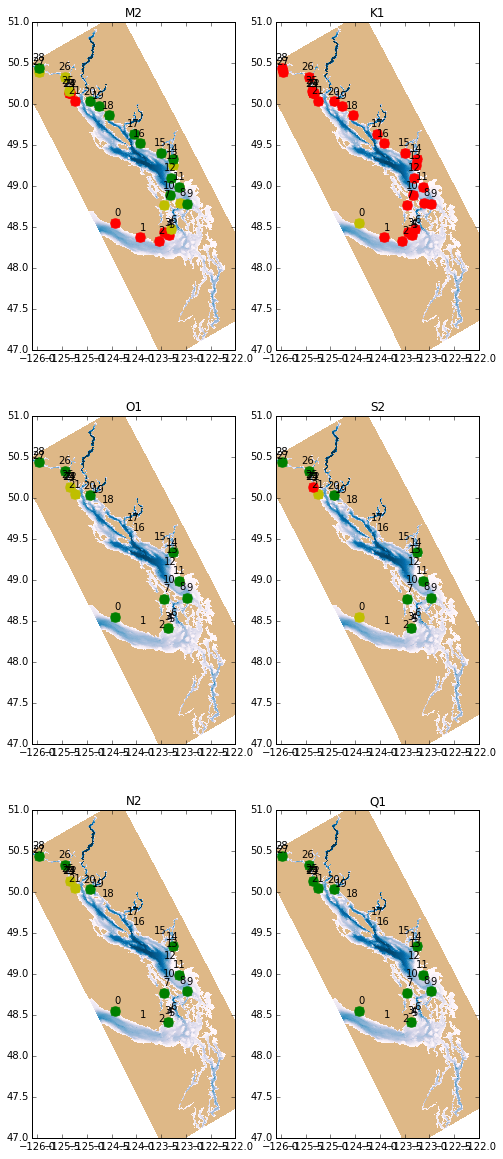

In [51]:
cmap = plt.get_cmap('PuBu')
cmap.set_bad('burlywood')

fig,axs=plt.subplots(3, 2, figsize=(8,20))

constituent = ('M2', 'K1', 'O1', 'S2', 'N2', 'Q1')
error_D = (D_M2, D_K1, D_O1, D_S2, D_N2, D_Q1)


for row in range(3):

    for ax, error_D1, const in zip(axs[row], error_D[row*2:row*2+2], constituent[row*2:row*2+2]):
        ax.pcolormesh(X,Y,bathy,cmap='PuBu')

        for stn in range(numsta):
            location = stations_obs[stn]
            lon=-harm_obs.lon[harm_obs.site==location]
            lat=harm_obs.lat[harm_obs.site==location]
            if error_D1 [stn] <= 0.05:
                ax.plot(lon,lat,'og',label=location,markersize=10,markeredgecolor='g')
            if error_D1 [stn] > 0.1:
                ax.plot(lon,lat,'or',label=location,markersize=10,markeredgecolor='r')
            if 0.1 >= error_D1[stn] > 0.05:
                ax.plot(lon,lat,'oy',label=location,markersize=10,markeredgecolor='y')
        
            ax.annotate(stn, xy = (lon,lat), xytext = (5,5),ha = 'right', va = 'bottom',
                textcoords = 'offset points')
            ax.set_title(const)
        ax.axis([-126.1,-122,47,51])
   



##### First Plot: M2 D error. Second Plot: K1 D error. Markers increase in size as D error increases.

Green: D error <= 0.05, Yellow: 0.05 < D error <= 0.1, Red: D error > 0.1

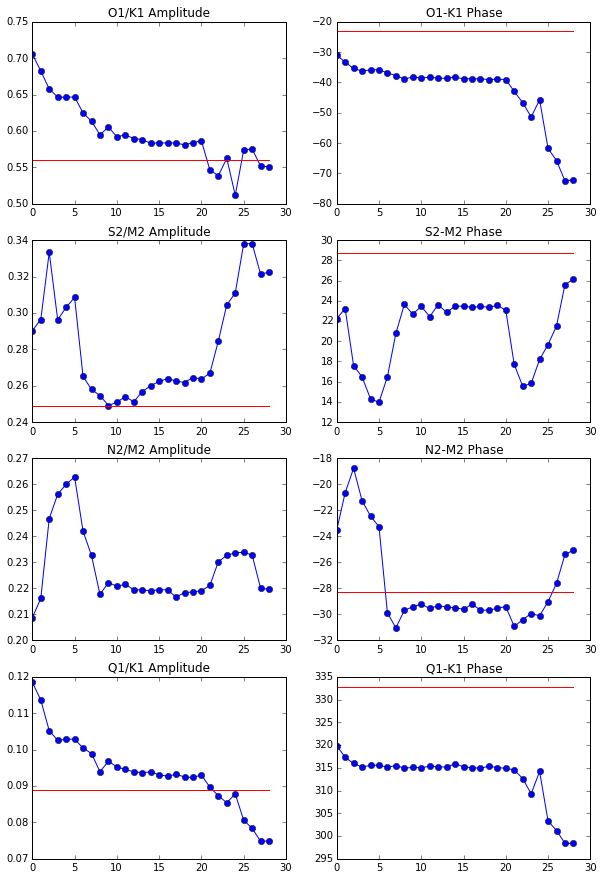

In [52]:
fig, axs = plt.subplots(4,2,figsize=(10,15))
axs[0,0].plot(np.array(O1_amp)/np.array(K1_amp), '-bo', label = 'model')
axs[0,0].plot((0,28),(0.560,0.560), 'r-', label = 'observation')
axs[0,0].set_title('O1/K1 Amplitude')
pha_uw = 180./np.pi * np.unwrap((np.array(O1_pha)-np.array(K1_pha))*np.pi/180.)
axs[0,1].plot(pha_uw, '-bo', label = 'model')
axs[0,1].plot((0,28),(-22.9,-22.9), 'r-', label = 'observation')
axs[0,1].set_title('O1-K1 Phase')

axs[1,0].plot(np.array(S2_amp)/np.array(M2_amp), '-bo', label = 'model')
axs[1,0].plot((0,28),(0.249,0.249), 'r-', label = 'observation')
axs[1,0].set_title('S2/M2 Amplitude')
pha_uw = 180./np.pi * np.unwrap((np.array(S2_pha)-np.array(M2_pha))*np.pi/180.)
axs[1,1].plot(pha_uw, '-bo', label = 'model')
axs[1,1].plot((0,28),( 28.7, 28.7), 'r-', label = 'observation')
axs[1,1].set_title('S2-M2 Phase')

axs[2,0].plot(np.array(N2_amp)/np.array(M2_amp), '-bo', label = 'model')
axs[2,0].plot((0,28),(0.200,0.200), 'r-', label = 'observation')
axs[2,0].set_title('N2/M2 Amplitude')

pha_uw = 180./np.pi * np.unwrap((np.array(N2_pha)-np.array(M2_pha))*np.pi/180.)
axs[2,1].plot(pha_uw, '-bo', label = 'model')
axs[2,1].plot((0,28),(-28.3, -28.3), 'r-', label = 'observation')
axs[2,1].set_title('N2-M2 Phase')

axs[3,0].plot(np.array(Q1_amp)/np.array(K1_amp), '-bo', label = 'model')
axs[3,0].plot((0,28),(0.089,0.089), 'r-', label = 'observation')
axs[3,0].set_title('Q1/K1 Amplitude')

pha_uw = 180./np.pi * np.unwrap((np.array(Q1_pha)-np.array(K1_pha))*np.pi/180.)
axs[3,1].plot(pha_uw+360., '-bo', label = 'model')
axs[3,1].plot((0,28),(-27.3+360,-27.3+360), 'r-', label = 'observation')
axs[3,1].set_title('Q1-K1 Phase')


In [43]:
sample = 17
start = np.zeros(sample)
tend = np.zeros(sample)
for i in range(sample):
    start[i] = 196+(480-196)*np.random.rand()
    tend[i] = te-(480-196)*np.random.rand()
print start
print tend
timelength = (tend-start)/96.
print np.mean(timelength),2*np.std(timelength)
print time[start[1]:tend[1]]


[ 405.80882695  278.27432509  464.55433292  287.31473207  358.78167357
  408.55456076  209.34371276  472.63640888  247.54685559  382.02621215
  288.20918732  419.14971435  257.26328312  228.13300147  274.21809934
  359.08374506  233.84225255]
[ 1692.41674219  1789.59647721  1747.14892721  1686.06722752  1705.16664396
  1735.0980617   1764.02625026  1797.69341525  1681.16875708  1806.11610612
  1845.33252345  1664.50001905  1863.86584981  1780.04090478  1671.09642738
  1687.3512495   1801.8208656 ]
14.7939739731 2.36645917339
[ 259.25  259.75  260.25 ...,  958.75  959.25  959.75]


In [44]:
#allocate space for our arrays
M2_amp=np.zeros((numsta,sample)); M2_pha=np.zeros((numsta,sample))
K1_amp=np.zeros((numsta,sample)); K1_pha=np.zeros((numsta,sample))
O1_amp=np.zeros((numsta,sample)); O1_pha=np.zeros((numsta,sample))
S2_amp=np.zeros((numsta,sample)); S2_pha=np.zeros((numsta,sample))
N2_amp=np.zeros((numsta,sample)); N2_pha=np.zeros((numsta,sample))
Q1_amp=np.zeros((numsta,sample)); Q1_pha=np.zeros((numsta,sample))




for it,tst,tet in zip(range(sample),start.astype(int),tend.astype(int)):
    
    timeplus = np.zeros([5,tet-tst])
  
    for stn in range(numsta):
        fT1 = NC.Dataset(name+stations[stn]+'.nc','r')
        time = (fT1.variables["time_counter"][tst:tet]-timeinc)/3600.  # want hours not seconds
        ssh = fT1.variables["sossheig"][:,0,0]
        timeplus[0] = time
        timeplus[1] = P1K1_amp[stn]*np.ones_like(time); timeplus[2] = P1K1_pha[stn]*np.ones_like(time)
        timeplus[3] = K2S2_amp[stn]*np.ones_like(time); timeplus[4] = K2S2_pha[stn]*np.ones_like(time)        
        
        fitted, cov = curve_fit(sixplustwo,timeplus,ssh[tst:tet]) 
        if fitted[0] < 0:
            fitted[0] = -fitted[0]
            fitted[1] = fitted[1]+180

        M2_amp[stn,it] = fitted[0]
        pha = fitted[1]
        if  pha > 360:
            pha=pha-360
        elif pha < 0:
            pha = pha + 360
        M2_pha[stn,it] = pha
        
        if fitted[2] < 0:
            fitted[2] = -fitted[2]
            fitted[3] = fitted[3]+180

        K1_amp[stn,it] = fitted[2]
        pha= fitted[3]
        if  pha > 360:
            pha=pha-360
        K1_pha[stn,it]= pha   
                
        if fitted[4] < 0:
            fitted[4] = -fitted[4]
            fitted[5] = fitted[5]+180
        O1_amp[stn,it] =fitted[4]
        pha= fitted[5]
        if  pha > 360:
            pha=pha-360
        O1_pha[stn,it]= pha 
        
        if fitted[6] < 0:
            fitted[6] = -fitted[6]
            fitted[7] = fitted[7]+180
        S2_amp[stn,it] =fitted[6]
        pha= fitted[7]
        if  pha > 360:
            pha=pha-360
        S2_pha[stn,it]= pha 
    
        if fitted[8] < 0:
            fitted[8] = -fitted[8]
            fitted[9] = fitted[9]+180
        N2_amp[stn,it] = fitted[8]
        pha= fitted[9]
        if  pha > 360:
            pha=pha-360
        N2_pha[stn,it] = pha
        
        if fitted[10] < 0:
            fitted[10] = -fitted[10]
            fitted[11] = fitted[11]+180
        Q1_amp[stn,it] = fitted[10]
        pha= fitted[11]
        if  pha > 360:
            pha=pha-360
        Q1_pha[stn,it] = pha
        

In [45]:
jdef = range(3)
south = range(14,18)
north = range(27,29)
print 'M2'
print '     JdeFuca'
print np.mean(M2_amp[jdef]),2*np.std(np.mean(M2_amp[jdef],axis=0))
print np.mean(M2_amp_obs[jdef]), np.mean(M2_amp_obs[jdef])-np.mean(M2_amp[jdef])
print np.mean(M2_amp_obs[jdef])/np.mean(M2_amp[jdef])
print np.mean(M2_pha[jdef]),2*np.std(np.mean(M2_pha[jdef],axis=0))
print np.mean(M2_pha_obs[jdef]), np.mean(M2_pha_obs[jdef])-np.mean(M2_pha[jdef])
print '     South'
print np.mean(M2_amp[south]),2*np.std(np.mean(M2_amp[south],axis=0))
print np.mean(M2_amp_obs[south]), np.mean(M2_amp_obs[south])-np.mean(M2_amp[south])
print np.mean(M2_amp_obs[south])/np.mean(M2_amp[south])
print np.mean(M2_pha[south]),2*np.std(np.mean(M2_pha[south],axis=0))
print np.mean(M2_pha_obs[south]), np.mean(M2_pha_obs[south])-np.mean(M2_pha[south])
print '     North'
print np.mean(M2_amp[north]),2*np.std(np.mean(M2_amp[north],axis=0))
print np.mean(M2_amp_obs[north]), np.mean(M2_amp_obs[north])-np.mean(M2_amp[north])
print np.mean(M2_amp_obs[north])/np.mean(M2_amp[north])
print np.mean(M2_pha[north]),2*np.std(np.mean(M2_pha[north],axis=0))
print np.mean(M2_pha_obs[north]), np.mean(M2_pha_obs[north])-np.mean(M2_pha[north])
print '==============================================='
print 'K1'
print '     JdeFuca'
print np.mean(K1_amp[jdef]),2*np.std(np.mean(K1_amp[jdef],axis=0))
print np.mean(K1_amp_obs[jdef]), np.mean(K1_amp_obs[jdef])-np.mean(K1_amp[jdef])
print np.mean(K1_amp_obs[jdef])/np.mean(K1_amp[jdef])
print np.mean(K1_pha[jdef]),2*np.std(np.mean(K1_pha[jdef],axis=0))
print np.mean(K1_pha_obs[jdef]), np.mean(K1_pha_obs[jdef])-np.mean(K1_pha[jdef])
print '     South'
print np.mean(K1_amp[south]),2*np.std(np.mean(K1_amp[south],axis=0))
print np.mean(K1_amp_obs[south]), np.mean(K1_amp_obs[south])-np.mean(K1_amp[south])
print np.mean(K1_amp_obs[south])/np.mean(K1_amp[south])
print np.mean(K1_pha[south]),2*np.std(np.mean(K1_pha[south],axis=0))
print np.mean(K1_pha_obs[south]), np.mean(K1_pha_obs[south])-np.mean(K1_pha[south])
print '     North'
print np.mean(K1_amp[north]),2*np.std(np.mean(K1_amp[north],axis=0))
print np.mean(K1_amp_obs[north]), np.mean(K1_amp_obs[north])-np.mean(K1_amp[north])
print np.mean(K1_amp_obs[north])/np.mean(K1_amp[north])
print np.mean(K1_pha[north]),2*np.std(np.mean(K1_pha[north],axis=0))
print np.mean(K1_pha_obs[north]), np.mean(K1_pha_obs[north])-np.mean(K1_pha[north])
print '==============================================='

M2
     JdeFuca
0.55095364834 0.00283977050396
0.512333333333 -0.0386203150064
0.929902787425
252.285000693 0.559013559437
270.8 18.5149993067
     South
1.01390222449 0.00390919439864
0.95425 -0.0596522244891
0.941165703114
29.971337925 0.236318379202
31.175 1.20366207499
     North
1.1502873709 0.00261606635206
1.1705 0.020212629101
1.01757180824
273.097820681 0.318541096146
274.05 0.952179318563
K1
     JdeFuca
0.493244175188 0.00215190581354
0.542666666667 0.0494224914788
1.1001988345
257.217685836 0.10646222607
261.533333333 4.3156474975
     South
0.816247471775 0.00269706030232
0.8735 0.057252528225
1.07014114004
-76.6435367497 0.154972368989
285.95 362.59353675
     North
0.522433683459 0.00219741616444
0.5675 0.0450663165414
1.08626227207
186.518995407 215.989997497
260.7 74.1810045933


O1
     South
0.524331024336 0.00485796201768
0.560324825986 0.0359938016501
1.06864709502
-21.7782515501 0.561224836887
-22.9 -1.12174844992
     North
0.541066581322 0.00655863053757
0.576344086022 0.0352775047
1.06519993272
56.5773708535 215.901372021
-18.96 -75.5373708535
S2
south
0.235188950628 0.00211626441333
0.249455337691 0.0142663870626
1.06065925727
394.070564191 1.18113930256
28.7 -365.370564191
north
0.317250876657 0.00600871488136
0.329291204099 0.0120403274417
1.03795206988
31.7611803208 0.288716073023
29.4 -2.36118032077


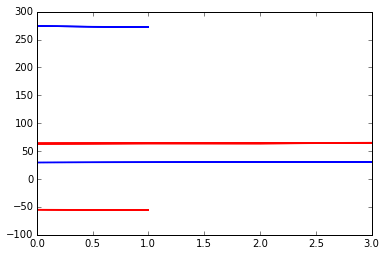

In [46]:
print 'O1'
print '     South'
print np.mean(O1_amp[south]/K1_amp[south]),2*np.std(np.mean(O1_amp[south]/K1_amp[south],axis=0))
print np.mean(O1_amp_obs[south]/K1_amp_obs[south]), (np.mean(O1_amp_obs[south]/K1_amp_obs[south])
                                                    -np.mean(O1_amp[south]/K1_amp[south]))
print np.mean(O1_amp_obs[south]/K1_amp_obs[south])/np.mean(O1_amp[south]/K1_amp[south])
print np.mean(O1_pha[south]-K1_pha[south]),2*np.std(np.mean(O1_pha[south]-K1_pha[south],axis=0))
print np.mean(O1_pha_obs[south]-K1_pha_obs[south]), (np.mean(O1_pha_obs[south]-K1_pha_obs[south])
                                                     -np.mean(O1_pha[south]-K1_pha[south]))
print '     North'
print np.mean(O1_amp[north]/K1_amp[north]),2*np.std(np.mean(O1_amp[north]/K1_amp[north],axis=0))
print np.mean(O1_amp_obs[north]/K1_amp_obs[north]), (np.mean(O1_amp_obs[north]/K1_amp_obs[north])
                                                    -np.mean(O1_amp[north]/K1_amp[north]))
print np.mean(O1_amp_obs[north]/K1_amp_obs[north])/np.mean(O1_amp[north]/K1_amp[north])
print np.mean(O1_pha[north]-K1_pha[north]),2*np.std(np.mean(O1_pha[north]-K1_pha[north],axis=0))
print np.mean(O1_pha_obs[north]-K1_pha_obs[north]), (np.mean(O1_pha_obs[north]-K1_pha_obs[north])
                                                     -np.mean(O1_pha[north]-K1_pha[north]))
print '==============================================='
print 'S2'
code = ('south','north')
for dir,dire in zip(code,(south,north)):
    print dir
    print np.mean(S2_amp[dire]/M2_amp[dire]),2*np.std(np.mean(S2_amp[dire]/M2_amp[dire],axis=0))
    print np.mean(S2_amp_obs[dire]/M2_amp_obs[dire]), (np.mean(S2_amp_obs[dire]/M2_amp_obs[dire])
                                                    -np.mean(S2_amp[dire]/M2_amp[dire]))
    print np.mean(S2_amp_obs[dire]/M2_amp_obs[dire])/np.mean(S2_amp[dire]/M2_amp[dire])
    unwrap = np.unwrap(np.array(S2_pha)*np.pi/180.)*180./np.pi
    M2_un = np.unwrap(np.array(M2_pha)*np.pi/180.)*180./np.pi
    plt.plot (unwrap[dire],'r',M2_un[dire],'b')
    print np.mean(unwrap[dire]-M2_un[dire])+360.,2*np.std(np.mean(unwrap[dire]-M2_un[dire],axis=0))
    print np.mean(S2_pha_obs[dire]-M2_pha_obs[dire]), (np.mean(S2_pha_obs[dire]-M2_pha_obs[dire])
                                                     -np.mean(unwrap[dire]-M2_un[dire]))-360.

In [47]:
const = ('Q1', 'N2')
model_amp = (Q1_amp, N2_amp)
model_pha = ()
for const, model_amp, model_pha, obs_amp, obs_pha in zip(('Q1','N2'),
                                                    (Q1_amp, N2_amp),(Q1_pha, N2_pha), 
                                                  (Q1_amp_obs, N2_amp_obs), (Q1_pha_obs, N2_pha_obs)):
    print const
    for dir,dire in zip(code,(south,north)):
        print dir
        print np.mean(model_amp[dire]/K1_amp[dire]),2*np.std(np.mean(model_amp[dire]/K1_amp[dire],axis=0))
        print np.mean(obs_amp[dire]/K1_amp_obs[dire]), (np.mean(obs_amp[dire]/K1_amp_obs[dire])
                                                    -np.mean(model_amp[dire]/K1_amp[dire]))
        print np.mean(obs_amp[dire]/K1_amp_obs[dire])/np.mean(model_amp[dire]/K1_amp[dire])
        unwrap = np.unwrap(np.array(model_pha)*np.pi/180.)*180./np.pi
        K1_un = np.unwrap(np.array(K1_pha)*np.pi/180.)*180./np.pi
        print np.mean(unwrap[dire]-K1_un[dire]),2*np.std(np.mean(unwrap[dire]-K1_un[dire],axis=0))
        print np.mean(obs_pha[dire]-K1_pha_obs[dire]), (np.mean(obs_pha[dire]-K1_pha_obs[dire])
                                                     -np.mean(unwrap[dire]-K1_un[dire]))

Q1
south
0.0844093383866 0.00193225965588
0.0893271461717 0.00491780778512
1.05826141845
337.627696584 3.06040397271
-27.3 -364.927696584
north
0.0868820594041 0.0044822685177
0.0955197132616 0.0086376538575
1.0994181528
156.548234332 1.16124908504
-25.11 -181.658234332
N2
south
0.247487062689 0.003196212284
0.213457076566 -0.0340299861228
0.862497919071
79.877266933 1.4246788847
-283.2 -363.077266933
north
0.496646357725 0.0139091473345
0.461111111111 -0.0355352466143
0.928449597865
168.583464314 0.314123795754
-11.88 -180.463464314


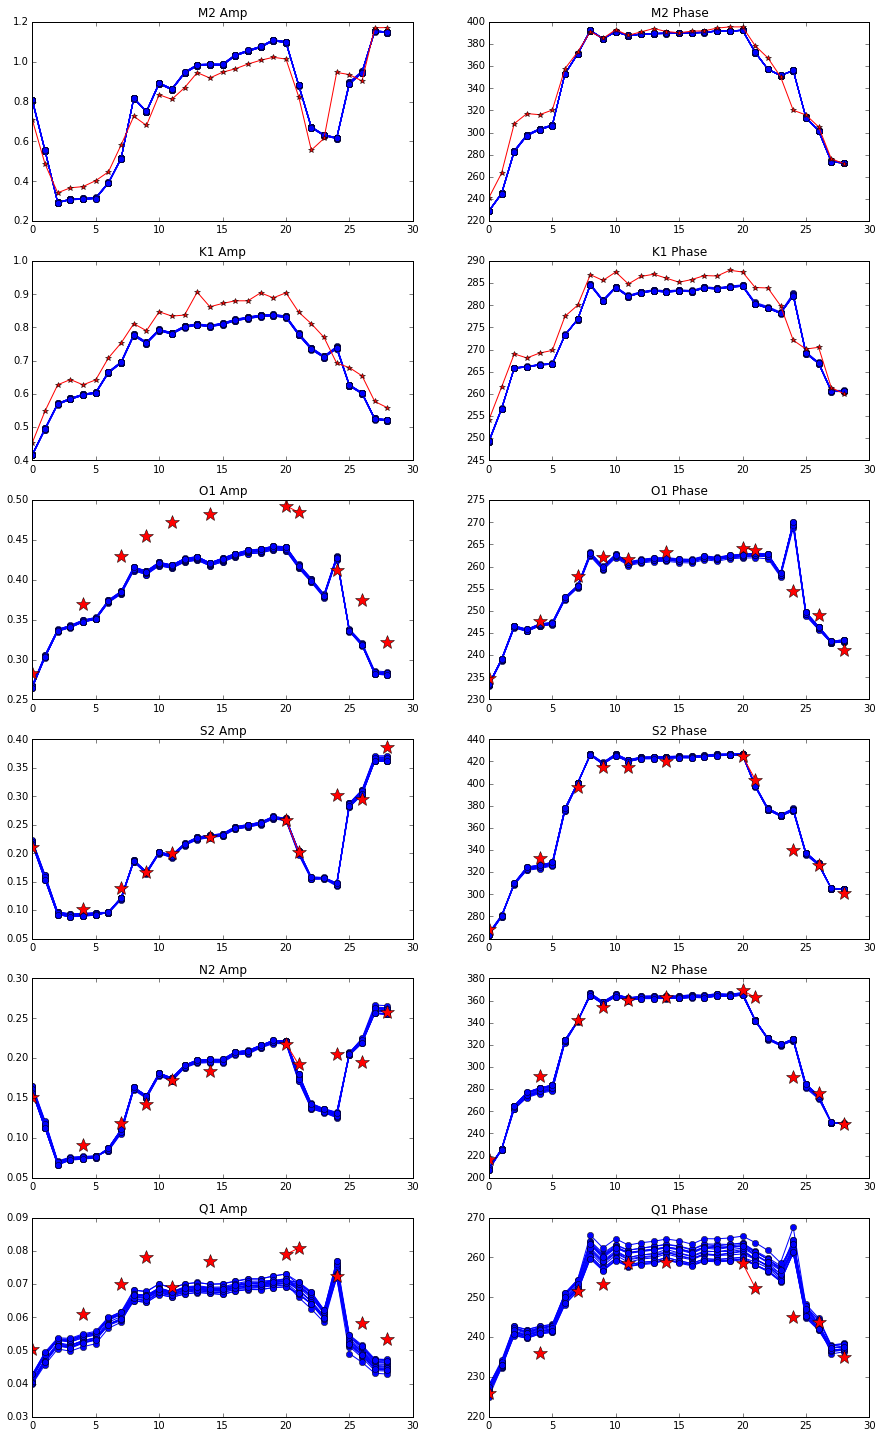

In [48]:
fig,axs = plt.subplots(6,2,figsize=(15,25))
for i in range(sample):
    pha_uw = 180./np.pi * np.unwrap(np.array(M2_pha[:,i])*np.pi/180.)
    axs[0,1].plot(pha_uw ,'-ob', label = 'model')
pha_uw = 180./np.pi * np.unwrap(np.array(M2_pha_obs)*np.pi/180.)
axs[0,1].plot(pha_uw, 'r-*', label = 'observation')
axs[0,1].set_title('M2 Phase')
for i in range(sample):
    axs[0,0].plot(M2_amp[:,i], '-bo', label = 'model')
axs[0,0].plot(M2_amp_obs, 'r-*', label = 'observation')
axs[0,0].set_title('M2 Amp')

for i in range(sample):
    if K1_pha[0,i] < -360:
        K1_pha[0,i] = K1_pha[0,i] +720.
    elif K1_pha[0,i] < 0:
        K1_pha[0,i] = K1_pha[0,i] + 360.
    pha_uw = 180./np.pi * np.unwrap(np.array(K1_pha[:,i])*np.pi/180.)
    axs[1,1].plot(pha_uw, '-bo', label = 'model')
axs[1,1].plot(K1_pha_obs, 'r-*', label = 'observation')
axs[1,1].set_title('K1 Phase')
for i in range(sample):
    axs[1,0].plot(K1_amp[:,i], '-bo', label = 'model')
axs[1,0].plot(K1_amp_obs, 'r-*', label = 'observation')
axs[1,0].set_title('K1 Amp')

for i in range(sample):
    if O1_pha[0,i] < 0:
        O1_pha[0,i] = O1_pha[0,i] + 360
    pha_uw = 180./np.pi * np.unwrap(np.array(O1_pha[:,i])*np.pi/180.)
    axs[2,1].plot(pha_uw, '-bo', label = 'model')
axs[2,1].plot(O1_pha_obs, 'r-*', label = 'observation', markersize = 15)
axs[2,1].set_title('O1 Phase')
for i in range(sample):
    axs[2,0].plot(O1_amp[:,i], '-bo', label = 'model')
axs[2,0].plot(O1_amp_obs, 'r-*', label = 'observation', markersize = 15)
axs[2,0].set_title('O1 Amp')

for i in range(sample):
    if S2_pha[0,i] < 0:
        S2_pha[0,i] = S2_pha[0,i] + 360
    pha_uw = 180./np.pi * np.unwrap(np.array(S2_pha[:,i])*np.pi/180.)
    axs[3,1].plot(pha_uw, '-bo', label = 'model')
pha_uw = 180./np.pi * np.unwrap(np.array(S2_pha_obs)*np.pi/180.)
vsmall = 1e-6
pha_uwm = np.ma.masked_array(pha_uw, mask=(abs(pha_uw-360)<vsmall))
axs[3,1].plot(pha_uwm, 'r-*', label = 'observation', markersize = 15)
axs[3,1].set_title('S2 Phase')
for i in range(sample):
    axs[3,0].plot(S2_amp[:,i], '-bo', label = 'model')
axs[3,0].plot(S2_amp_obs, 'r-*', label = 'observation', markersize = 15)
axs[3,0].set_title('S2 Amp')


for i in range(sample):
    axs[4,0].plot(N2_amp[:,i], '-bo', label = 'model')
axs[4,0].plot(N2_amp_obs, 'r-*', label = 'observation', markersize = 15)
axs[4,0].set_title('N2 Amp')
for i in range(sample):
    pha_uw = 180./np.pi * np.unwrap(np.array(N2_pha[:,i])*np.pi/180.)
    axs[4,1].plot(pha_uw, '-bo', label = 'model')
pha_uw = 180./np.pi * np.unwrap(np.array(N2_pha_obs)*np.pi/180.)
pha_uwm = np.ma.masked_array(pha_uw, mask=(abs(pha_uw-360)<vsmall))
axs[4,1].plot(pha_uwm, 'r-*', label = 'observation', markersize = 15)  
axs[4,1].set_title('N2 Phase')

for i in range(sample):
    axs[5,0].plot(Q1_amp[:,i], '-bo', label = 'model')
axs[5,0].plot(Q1_amp_obs, 'r-*', label = 'observation', markersize = 15)
axs[5,0].set_title('Q1 Amp')
for i in range(sample):
    pha_uw = 180./np.pi * np.unwrap(np.array(Q1_pha[:,i])*np.pi/180.)
    for j in range(numsta):
        if pha_uw[j] < 0:
            pha_uw[j] += 360
    axs[5,1].plot(pha_uw, '-bo', label = 'model')
axs[5,1].plot(Q1_pha_obs, 'r-*', label = 'observation', markersize = 15)
axs[5,1].set_title('Q1 Phase')
